# Importing packages and load CNN

In [1]:
# Load the extension
%load_ext autoreload
# Autoreload all modules
%autoreload 2

In [2]:
from funcs import *

# Telling the notebook to make plots inline.
%matplotlib inline

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

Saving imgages in /home/controls/Beam_auto_alignment/Data/Actual_cavity_Fittest_points_per_gen_2019-12-25_01-02

Cavity Mirror scanning range is [0, 2.8e-06] micron. The used range [0, 1.4e-07] micron should not go out.
Steering Mirror scanning range is [-0.0262, 0.0262] rad. The used range [-0.0262, 0.0262] rad should not go out.


## Start camera and DAC

In [3]:
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
print("Using Camera ", camera.GetDeviceInfo().GetModelName())
camera.Open()

# Sanity checks
print('Camera Auto Gain is :', camera.GainAuto())
if camera.GainAuto() == 'Off':
    print('Safe to go ahead with the code..')
else:
    print('***Warning: Camera Auto Gain is ON!***\nTurn it off using Pylon software.')
camera.ExposureTimeAbs = Exposure # microseconds

# Start DAC
start_channel = 1
bus = busworks.BusWorks_DAC()
bus.start()
print("DAC on IP: ", bus.address)

Using Camera  acA720-290gm
Camera Auto Gain is : Off
Safe to go ahead with the code..
DAC on IP:  192.168.1.231


## Initial State

Initial condition: 109.38555908203125


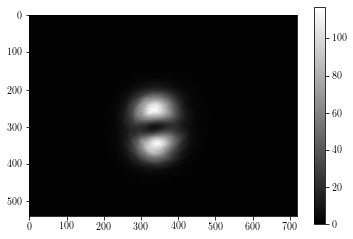

In [4]:
Img_initial = Capture_image(1000, camera)
print('Initial condition: {}'.format(Img_initial.sum()/n_pixl**2))
plt.imshow(Img_initial, cmap=cm.binary_r)
plt.colorbar()

In [5]:
# Initial condition of beam
current_beam_status = np.zeros(num_params)

## Alignment loop

In [6]:
Range = Range_orig

In [ ]:
# Creating the initial population of deltas
new_pop_deltas = sample_d(Range, shape=pop_size)
print("\nRange:", Range, "x waist")
# sess = tf.Session()

gen = 0
mode_stability = 0
mode_old = (50,50)
# dont_alter_z_cm = False
t0 = time.time()

# GA loop
for gen in range(100):
    # Shrink range
    Range *= shrink_factor
    print("\n\n Gen: {} Range: {} x waist".format(gen+1, Range))
    # if dont_alter_z_cm:
    #     new_pop_deltas[:,-1] = 0.
    if gen == 0:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=False)
    else:
        current_beam_status, new_pop_deltas, fitness = calc_pop_fitness(current_beam_status, \
        new_pop_deltas, fitness, camera, bus, only_offsprings=True)
    # Selecting the best parents in the population for mating.
    current_beam_status, parents, parents_fitness, Img_is_saturated, image = select_mating_pool(current_beam_status, new_pop_deltas, fitness, num_parents_mating, t0, gen, camera, bus, \
                           show_the_best=True, save_best=True)
    # Generating next generation using crossover.
    offspring_crossover = crossover(parents, (pop_per_gen - num_parents_mating, num_params))
    # Adding some variations to the offsrping using mutation.
    offspring_mutation = mutation(offspring_crossover, Range)
    # Creating the new population based on the parents and offspring.
    new_pop_deltas[:num_parents_mating, :] = parents
    new_pop_deltas[num_parents_mating:, :] = offspring_mutation
    fitness[:num_parents_mating] = parents_fitness
    fitness[num_parents_mating:] *= 0.
    # # Scan the cavity and regain the max power point in z_CM
    # current_beam_status, new_pop_deltas, img = scan_cavity(current_beam_status, new_pop_deltas, \
    #                                                        Range, Sz, camera, bus, show_fig=True)
    mode_new = Find_mode2(image, separation1=45, corner=0, show_fig=True, show_basis=True)
    if gen > 0:
        if np.all(mode_new == mode_old):
            mode_stability += 1
        else:
            mode_stability = 0
        # check mode stability
        if mode_stability == 3 and np.any(mode_new != (0,0)):
            print('Jumping to fundamental mode..')
            current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
                                                                        mode_new, camera, bus, show_fig=True)
        elif mode_stability > 3 and np.any(mode_new != (0,0)):
            print('Trying alternate jump..')
            current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
                                                                        mode_new, camera, bus, Sign=-1, show_fig=True)
#             print('Scanning the cavity..')
            current_beam_status, new_pop_deltas, img = scan_cavity(current_beam_status, new_pop_deltas, \
                                                                   1.1*Range, Sz, camera, bus, show_fig=True)
        elif mode_stability == 5 and np.all(mode_new == (0,0)):
            print('Fundamental mode identified! Exiting..')
            break
    print('\n*****  Mode is {} - occurances: {}  *****\n'.format(mode_new, mode_stability+1))
    mode_old = mode_new

    # if Img_is_saturated or max(fitness) > 200. or gen > 15:
    #     Range = Range_orig*shrink_factor**4
    #     Img_is_saturated = False
    #     print('Testing mode...')
    #     mode = Find_mode2(image, separation1=5, corner=0, show_fig=True, show_basis=True)
    #     print('Mode is {}'.format(mode))
    #     if np.all(mode == (0,0)):
    #         print('Fundamental mode identified! Exiting..')
    #         break
    #     else:
    #         # taking a jump in z_CM to make the cavity resonant to fundamental mode only
    #         current_beam_status, new_pop_deltas, _ = jump_2_fundamental(current_beam_status, new_pop_deltas, \
    #                                                                     mode, camera, bus, show_fig=True)
    #         # freezing z_CM 
    #         # dont_alter_z_cm = True


Range: 0.002970808660911525 x waist


 Gen: 1 Range: 0.0018988052598522438 x waist


/home/controls/Beam_auto_alignment/src/funcs.py:121: RuntimeWarning: invalid value encountered in true_divide
  Basis_vect /= float(np.sqrt(Basis_vect[0]**2. + Basis_vect[1]**2.))
/home/controls/Beam_auto_alignment/src/funcs.py:124: RuntimeWarning: invalid value encountered in long_scalars
  slope /= (P1[0]-P0[0])


Time: 27.220508098602295, Fittest Parent: [-8.22703831e-07 -6.49282599e-08 -1.32606428e-06  5.14227996e-06
 -1.15709121e-09], Fitness: 41.615020751953125

*****  Mode is (0, 1) - occurances: 1  *****



 Gen: 2 Range: 0.0012136296296296287 x waist
Time: 54.660242557525635, Fittest Parent: [-3.04805977e-07  1.16644293e-06  9.27718398e-06  6.13954930e-07
 -8.73183598e-10], Fitness: 43.459991455078125

*****  Mode is (0, 1) - occurances: 2  *****



 Gen: 3 Range: 0.0007756966493918201 x waist


/home/controls/Beam_auto_alignment/src/funcs.py:121: RuntimeWarning: invalid value encountered in true_divide
  Basis_vect /= float(np.sqrt(Basis_vect[0]**2. + Basis_vect[1]**2.))
/home/controls/Beam_auto_alignment/src/funcs.py:124: RuntimeWarning: invalid value encountered in long_scalars
  slope /= (P1[0]-P0[0])


Time: 82.30508637428284, Fittest Parent: [ 2.79453190e-07  4.25591190e-08  1.00831494e-05 -4.76297212e-06
 -4.44128419e-10], Fitness: 40.83209228515625

*****  Mode is (0, 1) - occurances: 3  *****



 Gen: 4 Range: 0.0004957898828337956 x waist


# Plot status

21.8201904296875


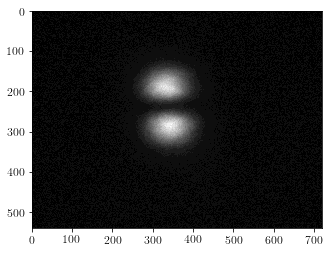

In [25]:
plt.interactive('off')
Img1 = Capture_image(300, camera)
print(Img1.sum()/n_pixl**2)
plt.imshow(Img1[::-1], cmap=cm.binary_r)

In [ ]:
peaks = Find_Peaks(Img1, separation=10, Sigma=1, show_ada_thresh=True, show_fig=True)

## Make gif of the images

In [9]:
import imageio

files = os.listdir(ImagesFolder)
files.sort()
images = []
for filename in files:
    images.append(imageio.imread(ImagesFolder+'/'+filename))
imageio.mimsave(ImagesFolder + '/movie.gif', images, duration=0.5)

In [10]:
%matplotlib notebook

In [ ]:
# fig,ax = plt.subplots(1,1)
# for f in range(10):
#     Img1 = Capture_image(300, camera)
#     # print(Img1.sum()/n_pixl**2)
#     ax.imshow(Img1, cmap=cm.binary_r)
#     fig.canvas.draw()
# #     time.sleep(0.01)

<IPython.core.display.Javascript object>


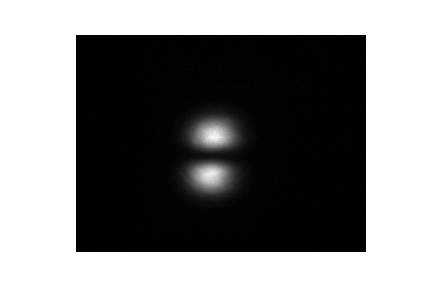

0.14 Pmax: 300.000
0.14 Pmax: 300.000
P_max reset to  11.16107177734375
0.11 Pmax: 11.161
wrong direction chosen.. reversing..
0.15 Pmax: 11.161
0.15 Pmax: 11.161
P_max reset to  15.043853759765625
0.12 Pmax: 15.044
wrong direction chosen.. reversing..
0.16 Pmax: 15.044
wrong direction chosen.. reversing..
0.16 Pmax: 15.044
0.16 Pmax: 15.044
0.16 Pmax: 15.044
P_max reset to  37.1507568359375
0.14 Pmax: 37.151
0.17 Pmax: 37.151
0.18 Pmax: 37.151
0.18 Pmax: 37.151
P_max reset to  31.7999267578125
0.15 Pmax: 31.800
wrong direction chosen.. reversing..
0.18 Pmax: 31.800
wrong direction chosen.. reversing..
0.18 Pmax: 31.800
wrong direction chosen.. reversing..
0.18 Pmax: 31.800
wrong direction chosen.. reversing..
0.19 Pmax: 31.800
0.20 Pmax: 31.800
P_max reset to  26.606536865234375
0.17 Pmax: 26.607
0.17 Pmax: 26.607
P_max reset to  24.726348876953125
0.17 Pmax: 24.726
wrong direction chosen.. reversing..
0.20 Pmax: 24.726
0.21 Pmax: 24.726
0.20 Pmax: 24.726
P_max reset to  32.7388305664

KeyboardInterrupt: 

<IPython.core.display.Javascript object>


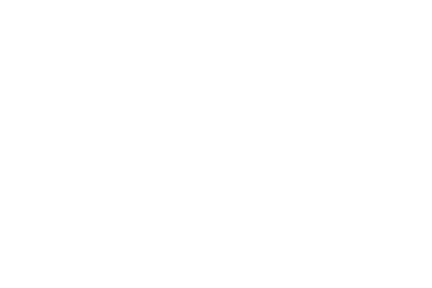

In [16]:
# Once GA has found the fundamental mode
# Digital locking
P_thresh = 0.9 		# thresh wrt max power that has to be maintained
P_max = 300.
P_old = 0.
z_step = 1e-8
locking_loop_on = False
direction = 1
P_was_increasing = 0
show_fig = True

if show_fig:
    fig,ax = plt.subplots(1,1)

while True:
    tt1 = time.time()
    Img = Capture_image(300, camera)
    Mode = Find_mode2(Img, separation1=10, Sigma1=1, Width=10, thresh=0.5, corner=0)
    P_new = Img.sum()/n_pixl**2./(Mode[0]+Mode[1]+1.)
    # activate loop if power falls below thresh
    if not locking_loop_on and P_new < P_thresh*P_max:
        locking_loop_on = True
    # if Power drops then reverse the direction
    if P_new < P_old:
        if P_was_increasing:
            locking_loop_on = False
            P_max = P_old
            print('P_max reset to ', P_max)
            P_was_increasing = 0
        else:
            pass
            print('wrong direction chosen.. reversing..')
        direction *= -1
    # if Power is increasing, note for how many steps did it increase
    if P_new > P_old:
        P_was_increasing += 1
    # Actual locking loop
    if locking_loop_on:
        # take the delta step
        current_beam_status[4] += direction*z_step
        # cumulatively subtracting each delta step from all deltas
        new_pop_deltas[:,4] -= direction*z_step
        Set_Voltage(current_beam_status, bus)
    # record the value before updation
    P_old = P_new
    if show_fig:
        # update image
        ax.imshow(Img, cmap=cm.binary_r)
        fig.canvas.draw()
    print('{0:1.2f} Pmax: {1:1.3f}'.format(time.time() - tt1, P_max))

# Stop Camera and DAC

In [ ]:
# Stop camera and DAC
camera.Close()
bus.stop()

In [ ]:
# Fundamental mode found at - 
# [-4.53647184e-04, -6.55543948e-04, -1.42826178e-03, -2.48699030e-03, 5.16627764e-07]